In [1]:
import numpy as np
import pandas as pd
import healpy as hp
import matplotlib
import matplotlib.dates as mdates
import math
from scipy import interpolate, stats, special
from scipy import arange, array, exp
from astropy.coordinates import SkyCoord

RAD2DEG = 180./np.pi
DEG2RAD=np.pi/180

In [2]:
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 8)
from scipy.interpolate import interp1d

Populating the interactive namespace from numpy and matplotlib


In [3]:
def spcang (ra1 , ra2, dec1, dec2):
    return np.arccos(np.cos(dec1*DEG2RAD)*np.cos(dec2*DEG2RAD)*np.cos((ra1-ra2)*DEG2RAD)+np.sin(dec1*DEG2RAD)*np.sin(dec2*DEG2RAD))*RAD2DEG
    
    
def signaless(n):
    normed_hist = \
    [  0.00000000e+00,  5.99855625e-06,  2.56068410e-06,  2.00041249e-04,
       4.96561472e-01,  1.80710446e+00,  1.53757070e+00,  6.19210631e-01,
       2.69402835e-01,  1.04740183e-01,  7.86432556e-02,  4.19244509e-02,
       2.51411438e-02,  9.83825515e-03,  4.66870813e-03,  2.57092417e-03,
       1.48438797e-03,  6.00967147e-04,  2.68416599e-04,  6.06027188e-05]
    bins_log10_signalness = \
    [-4., -3.8, -3.6, -3.4, -3.2, -3.,  -2.8, -2.6, -2.4, -2.2, -2.,  -1.8, -1.6, -1.4, -1.2,
     -1., -0.8, -0.6, -0.4, -0.2,  0. ]
    
    bins = np.asarray(bins_log10_signalness)
    bin_centers = bins[:-1] + 0.5 * (bins[1:] - bins[:-1])
    
    f2 = interp1d(bin_centers, normed_hist)
    xnew=np.linspace(-3.8,-0.1,40)
    
    cdf = np.cumsum(f2(xnew))
    cdf = cdf / cdf[-1]
    values = np.random.rand(n)
    value_bins = np.searchsorted(cdf, values)
    random_from_cdf = xnew[value_bins]
    return random_from_cdf

    
def LLH1(dec1,ra1,dec2,ra2,sigma1,sigma2,sig):
    sigma2 = stats.lognorm.rvs(0.463632912751, loc=0.0302994104141, scale=0.0741518054165, size=1, random_state=None)[0]#0.11#abs(random.normal(0.11,0.03)) #change HAWC sigmaR to be distributed around 0.1 for now
    if abs(ra1-ra2)>300:
        if ra1>ra2:
            ra1=ra1-360
        else:
            ra2=ra2-360
    ra_best = (ra1*sigma2**2+ra2*sigma1**2)/(sigma1**2+sigma2**2)
    if ra_best < 0 : ra_best_report = ra_best + 360
    else : ra_best_report = ra_best
    dec_best = (dec1*sigma2**2+dec2*sigma1**2)/(sigma1**2+sigma2**2)
    sigma = 1/(1/sigma1**2+1/sigma2**2)
    #llh1 = ((ra_best-ra1)**2+(dec_best-dec1)**2)/(2*sigma1**2) + \
          #2*np.log(sigma1) + ((ra_best-ra2)**2+(dec_best-dec2)**2)/(2*sigma2**2) + \
          #2*np.log(sigma2) - np.log(1-2*stats.norm.sf(abs(sig)))
            
    llh = -np.log(2*np.pi*sigma1)/2 - ((ra_best-ra1)**2+(dec_best-dec1)**2)/(2*sigma1**2)\
           -np.log(2*np.pi*sigma2)/2 - ((ra_best-ra2)**2+(dec_best-dec2)**2)/(2*sigma2**2)\
           + sig**2 
    
    return [dec_best, ra_best_report,llh,np.sqrt(sigma)] 

def LLH2(dec1,ra1,dec2,ra2,sigma1,sigma2,sig):
    sigma2 = stats.lognorm.rvs(0.463632912751, loc=0.0302994104141, scale=0.0741518054165, size=1, random_state=None)[0]#abs(random.normal(0.11,0.03)) #change HAWC sigmaR to be distributed around 0.1 for now
    if abs(ra1-ra2)>300:
        if ra1>ra2:
            ra1=ra1-360
        else:
            ra2=ra2-360
    ra_best = (ra1/sigma1**2+ra2/sigma2**2)/(1/sigma1**2+1/sigma2**2)
    if ra_best < 0 : ra_best = ra_best + 360
    else : ra_best = ra_best
    dec_best = (dec1/sigma1**2+dec2/sigma2**2)/(1/sigma1**2+1/sigma2**2)
    #llh1 = ((ra_best-ra1)**2+(dec_best-dec1)**2)/(2*sigma1**2) + \
          #2*np.log(sigma1) + ((ra_best-ra2)**2+(dec_best-dec2)**2)/(2*sigma2**2) + \
          #2*np.log(sigma2) - np.log(1-2*stats.norm.sf(abs(sig)))
    
    sigmap2 = 1/(1/sigma1**2 + 1/sigma2**2)
    #trying to be conservative
    sigc = sigma1**2 + sigma2**2
    dth = spcang(ra1,ra2,dec1,dec2)
    llh = -np.log(2*np.pi*sigc)/2 - dth**2/(2*sigc) + sig**2
    return [dec_best, ra_best,llh,np.sqrt(sigc)] 

def LLH3(dec1,ra1,dec2,ra2,sig1,sig2,sig):
    #Setting variables
    dst = spcang(ra1 , ra2, dec1, dec2)
    ra1=ra1*DEG2RAD
    dec1=dec1*DEG2RAD
    ra2=ra2*DEG2RAD
    dec2=dec2*DEG2RAD
    sig2 = stats.lognorm.rvs(0.463632912751, loc=0.0302994104141, scale=0.0741518054165, size=1, random_state=None)[0]#abs(random.normal(0.11,0.03)) #change HAWC sigmaR to be distributed around 0.1 for now
    
    #Finding the best position
    sig0=1/(1/sig1**2+1/sig2**2)
    #now we calculate f, the distance from particle 1 to best fit position
    f=sig0/sig2**2 #f should be between 0 and 1
    #define some intermediate parameters
    a=np.sin((1-f)*dst*DEG2RAD)/np.sin(dst*DEG2RAD)
    b=np.sin(f*dst*DEG2RAD)/np.sin(dst*DEG2RAD)
    x=a*np.cos(dec1)*np.cos(ra1)+b*np.cos(dec2)*np.cos(ra2)
    y=a*np.cos(dec1)*np.sin(ra1)+b*np.cos(dec2)*np.sin(ra2)
    z=a*np.sin(dec1)+b*np.sin(dec2)
    #now plug these parameters into the arctan2 function (quadrant sensitive arctangent)
    ra0=np.arctan2(y,x)
    dec0=np.arctan2(z,np.sqrt(x**2+y**2))
    ra0%=2*np.pi #use modulo operator to make sure ra falls between 0 and 2pi
    ra_best=ra0*RAD2DEG
    dec_best=dec0*RAD2DEG
    if ra_best < 0 : ra_best = ra_best + 360
    else : ra_best = ra_best
    #print dec1*RAD2DEG, dec2*RAD2DEG, dec_best, ra1*RAD2DEG, ra2*RAD2DEG, ra_best, a, b
        
    #Calculating the likelihood
    #Spatial coincidence
    sigc=sig1**2+ sig2**2 #Being conservatives in the error  
    pdst = special.erf(dst/(np.sqrt(2)*sigc)) #Probability of distance being less than ∆theta
    pndst = 1 - pdst #probability distance begin more than ∆theta
    if pdst!=1:
        term1 = np.log(pdst) - np.log(pndst)#-np.log(2*np.pi*sigc)/2
    else:
        term1 = -20
    
    
    #IC and HAWC contributions
    phwc = stats.norm.cdf(sig) #HAWC significances
    pIC = np.power(10,signaless(1))[0] #IC Signaless
    if pIC!=1: 
        term2 = sig**2 + np.log(pIC) - np.log(1-pIC)#sig**2
    else:
        term2 = sig**2
    
    if dst/(np.sqrt(2)*sigc)<6.:
        llh = term1 + term2 #+ term3  ##LIKELIHOOD
    else:
        llh = term1 #should be -20
    
    #llh =  - dst**2/(2*sigc)+sig**2#np.log(stats.uniform.rvs(0.,1))
    return [dec_best, ra_best, np.sqrt(sig0), np.sqrt(sigc), term1, term2, llh] 
    
def spcang_trange_llh1 (dfic, dfh, minspc):
    data_list = []
    i=0
   
    for h in dfh.itertuples():
        j=0
        dfw = dfic[(pd.to_datetime(h.HTime_i) <= pd.to_datetime(dfic['ICtime'])) & (pd.to_datetime(h.HTime_f) >= pd.to_datetime(dfic['ICtime']))]
        for ic in dfw.itertuples():
            
            spc = spcang(h.HRA, ic.ICRA, h.HDec, ic.ICDec)
            
            if spc < minspc :
                #print i,j
                llh_list = LLH1(ic.ICDec,ic.ICRA,h.HDec,h.HRA,ic.ICsigmaR,h.HsigmaR,h.Hsig)
                data_list.append((ic.ICDec, ic.ICRA, ic.ICsigmaR, ic.ICtime,
                      h.HDec, h.HRA, h.HsigmaR, h.HTime_i, h.HTime_c, h.HTime_f,h.Hduration,h.Hsig, spc,
                                  llh_list[0], llh_list[1], llh_list[3], llh_list[2]))
            j+=1
        i+=1
    result = pd.DataFrame(data_list, columns=['ICDec', 'ICRA' ,'ICsigmaR' ,'ICtime',
                                              'HDec','HRA','HsigmaR','HTime_i','HTime_c','HTime_f','Hduration','Hsig',
                                              'SpcAng','Best_fit_dec','Best_fit_ra','Best_pos_err','LLH'])
    return result

def spcang_trange_llh2 (dfic, dfh, minspc):
    data_list = []
    i=0
   
    for h in dfh.itertuples():
        j=0
        dfw = dfic[(pd.to_datetime(h.HTime_i) <= pd.to_datetime(dfic['ICtime'])) & (pd.to_datetime(h.HTime_f) >= pd.to_datetime(dfic['ICtime']))]
        for ic in dfw.itertuples():
            
            spc = spcang(h.HRA, ic.ICRA, h.HDec, ic.ICDec)
            
            if spc < minspc :
                #print i,j
                llh_list = LLH2(ic.ICDec,ic.ICRA,h.HDec,h.HRA,ic.ICsigmaR,h.HsigmaR,h.Hsig)
                data_list.append((ic.ICDec, ic.ICRA, ic.ICsigmaR, ic.ICtime,
                      h.HDec, h.HRA, h.HsigmaR, h.HTime_i, h.HTime_c, h.HTime_f,h.Hduration,h.Hsig, spc,
                                  llh_list[0], llh_list[1], llh_list[3], llh_list[2]))
            j+=1
        i+=1
    result = pd.DataFrame(data_list, columns=['ICDec', 'ICRA' ,'ICsigmaR' ,'ICtime',
                                              'HDec','HRA','HsigmaR','HTime_i','HTime_c','HTime_f','Hduration','Hsig',
                                              'SpcAng','Best_fit_dec','Best_fit_ra','Best_pos_err','LLH'])
    return result

def spcang_trange_llh3 (dfic, dfh, minspc):
    data_list = []
    i=0
   
    for h in dfh.itertuples():
        j=0
        dfw = dfic[(pd.to_datetime(h.HTime_i) <= pd.to_datetime(dfic['ICtime'])) & (pd.to_datetime(h.HTime_f) >= pd.to_datetime(dfic['ICtime']))]
        for ic in dfw.itertuples():
            
            spc = spcang(h.HRA, ic.ICRA, h.HDec, ic.ICDec)
            #th1 = SkyCoord(h[1][1],h[1][0],unit='deg')
            #th2 = SkyCoord(ic[1][1],ic[1][0],unit='deg')
            #spc = th1.separation(th2).value
            
            if spc < minspc :
                #print i,j
                llh_list = LLH3(ic.ICDec,ic.ICRA,h.HDec,h.HRA,ic.ICsigmaR,h.HsigmaR,h.Hsig)
                data_list.append((ic.ICDec, ic.ICRA, ic.ICsigmaR, ic.ICtime,
                      h.HDec, h.HRA, h.HsigmaR, h.HTime_i, h.HTime_c, h.HTime_f,h.Hduration,h.Hsig, spc,
                                  llh_list[0], llh_list[1], llh_list[2], llh_list[3], llh_list[4], llh_list[5],llh_list[6]))
            j+=1
        i+=1
    result = pd.DataFrame(data_list, columns=['ICDec', 'ICRA' ,'ICsigmaR' ,'ICtime',
                                              'HDec','HRA','HsigmaR','HTime_i','HTime_c','HTime_f','Hduration','Hsig',
                                              'SpcAng','Best_fit_dec','Best_fit_ra','Best_pos_err','SigQ','T1','T2','LLH'])
    return result


In [5]:
#dfh = pd.read_csv("/Users/Azadeh/Desktop/related_amon/IC-HAWC/files/monthly_maps/HAWC-Jan16.csv")
dfh = pd.read_csv("hawc_data_2.csv")
dfh['HTime_i']=pd.to_datetime(dfh['HTime_i'])
dfh['HTime_f']=pd.to_datetime(dfh['HTime_f'])

In [7]:
dfic = pd.read_csv("IC-singlet-Dec15old-Jan16new-shuffled.csv")
dfic['ICtime']=pd.to_datetime(dfic['ICtime'])
dfic = dfic.sort_values(by='ICtime')

In [8]:
dfic.head(500)[205:210]

,ICDec,ICRA,ICsigmaR,ICtime,ICmsec
5543,70.0049,223.4110,1.01584,2016-01-01 19:47:36,201092
3931,34.7977,275.1130,1.79516,2016-01-01 20:01:02,217920
4350,64.8118,270.5510,3.07204,2016-01-01 20:10:37,347249
4824,80.8512,252.5080,3.06175,2016-01-01 20:14:46,800816
5001,44.1483,53.5088,1.37765,2016-01-01 20:16:41,167690


In [199]:
%%time
spca = 3.5
# df_result1 = spcang_trange_llh1(dfic, dfh, spca)
# df_result1.to_csv("IC_HAWC_bkg_1.csv",index=False,encoding='utf-8')
# df_result2 = spcang_trange_llh2(dfic, dfh, spca)
# df_result2.to_csv("IC_HAWC_bkg_2.csv",index=False,encoding='utf-8')
df_result3 = spcang_trange_llh3(dfic, dfh, spca)
df_result3.to_csv("IC_HAWC_bkg_3.csv",index=False,encoding='utf-8')

CPU times: user 55.4 s, sys: 410 ms, total: 55.8 s
Wall time: 56.8 s


In [200]:
df_result3.head(5)

,ICDec,ICRA,ICsigmaR,ICtime,HDec,HRA,HsigmaR,HTime_i,HTime_c,HTime_f,Hduration,Hsig,SpcAng,Best_fit_dec,Best_fit_ra,Best_pos_err,SigQ,T1,T2,LLH
0,34.7977,275.113,1.795160,2016-01-01 20:01:02,33.3312,271.890,0.75,2016-01-01 14:18:31,2016-01-01 17:54:04,2016-01-01 21:29:37,7.18509,3.20798,3.045947,33.335769,271.899599,0.098818,1.797886,0.636539,3.289826,3.926365
1,34.7977,275.113,1.795160,2016-01-01 20:01:02,34.5452,272.110,0.75,2016-01-01 14:19:41,2016-01-01 17:54:56,2016-01-01 21:30:11,7.17481,3.60946,2.482528,34.545742,272.115614,0.077743,1.796846,0.233253,6.464291,6.697544
2,16.6642,272.744,0.834174,2016-01-01 16:36:03,18.3277,271.934,0.75,2016-01-01 14:23:02,2016-01-01 17:54:22,2016-01-01 21:25:42,7.04470,2.96565,1.834115,18.268602,271.963063,0.157305,0.849414,4.496989,2.449965,6.946953
3,34.7977,275.113,1.795160,2016-01-01 20:01:02,35.8232,276.065,0.75,2016-01-01 14:35:54,2016-01-01 18:10:42,2016-01-01 21:45:30,7.15974,2.89521,1.286515,35.819931,276.061915,0.101546,1.798039,-0.803277,2.256005,1.452727
4,26.6468,273.461,2.543030,2016-01-01 21:09:15,24.5012,276.328,0.75,2016-01-01 14:37:07,2016-01-01 18:11:51,2016-01-01 21:46:35,7.15769,3.39708,3.360062,24.504339,276.323931,0.096663,2.544869,-0.421686,4.976242,4.554557


In [201]:
len(df_result3)

1367

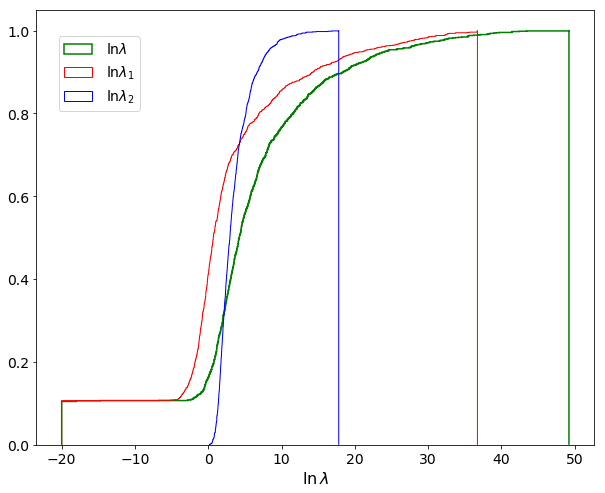

In [202]:
rcParams['figure.figsize'] = (10, 8)
rcParams['font.size']=14
# cllh=plt.hist(df_result1.LLH,cumulative=True,normed=1,
#          histtype='step',
#          color='b',
#          lw=1.5,
#          bins=2000,
#          label='llh1')
# cllh=plt.hist(df_result2.LLH,cumulative=True,normed=1,
#          histtype='step',
#          color='r',
#          lw=1.5,
#          bins=2000,
#          label='llh2')
cllh=plt.hist(df_result3.LLH,cumulative=True,normed=1,
         histtype='step',
         color='g',
         lw=1.5,
         bins=2000,
         label=r'$\ln \lambda$')
cllh1=plt.hist(df_result3.T1,cumulative=True,normed=1,
         histtype='step',
         color='r',
         lw=1.,
         bins=2000,
         label=r'$\ln \lambda_1$')
cllh2=plt.hist(df_result3.T2,cumulative=True,normed=1,
         histtype='step',
         color='b',
         lw=1.,
         bins=2000,
         label=r'$\ln \lambda_2$')
# cllh=plt.hist(df_result3.T3,cumulative=True,normed=1,
#          histtype='step',
#          color='k',
#          lw=1.,
#          bins=2000,
#          label='T3')
#xlim(-20,70)
perc2 = np.percentile(df_result3.LLH,99.99)
#plt.vlines(perc2,0,0.9999,color='green',linestyles='--',lw=1.5)
l=legend(bbox_to_anchor=(0.04,0.94),loc=2,borderaxespad=0,numpoints=1,fancybox=True,
         handletextpad=1,handlelength=2,prop={'size':14})
xlabel(r'$\ln \, \lambda$',fontsize=16)
savefig('/Users/hugo/AMON/Technical_Notes/IC-HAWC_Analysis/CLLH.pdf')

In [203]:
delta = (max(df_result3.LLH)+10)/100.
binst1 = (max(df_result3.T1)+10)/delta
binst2 = (max(df_result3.T2)-min(df_result3.T2))/delta
#binst3 = max(df_result3.T3)-min(df_result3.T3)/delta
#min(df_result3.ICsigmaR)
binst1

78.910874593554084

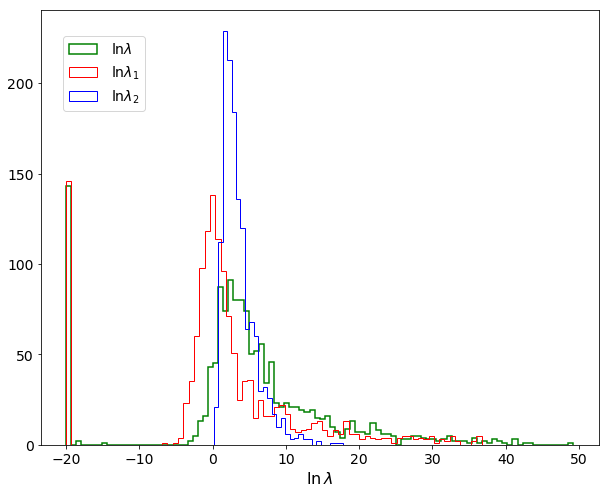

In [204]:
rcParams['figure.figsize'] = (10, 8)
# llh=plt.hist(df_result1.LLH,cumulative=False,normed=1,
#          histtype='step',
#          color='b',
#          lw=1.,
#          bins=200,
#          label='bkg')
# llh=plt.hist(df_result2.LLH,cumulative=False,normed=1,
#          histtype='step',
#          color='r',
#          lw=1.,
#          bins=200,
#          label='bkg')
llh=plt.hist(df_result3.LLH,cumulative=False,normed=0,
         histtype='step',
         color='g',
         lw=1.5,
         bins=100,
         label=r'$\ln \lambda$',range=[-20,max(df_result3.LLH)])
t1=plt.hist(df_result3.T1,cumulative=False,normed=0,
         histtype='step',
         color='r',
         lw=1.,
         bins=int(binst1),
         label=r'$\ln \lambda_1$',range=[-20,max(df_result3.T1)])
t2=plt.hist(df_result3.T2,cumulative=False,normed=0,
         histtype='step',
         color='b',
         lw=1.,
         bins=int(binst2),
         label=r'$\ln \lambda_2$',range=[min(df_result3.T2),max(df_result3.T2)])
# t3=plt.hist(df_result3.T3,cumulative=False,normed=0,
#          histtype='step',
#          color='k',
#          lw=1.,
#          bins=int(binst3),
#          label='T3')
l=legend(bbox_to_anchor=(0.04,0.94),loc=2,borderaxespad=0,numpoints=1,fancybox=True,
         handletextpad=1,handlelength=2,prop={'size':14})

xlabel("logLH")
#xlim(-10,70)
xlabel(r'$\ln \, \lambda$',fontsize=16)
savefig('/Users/hugo/AMON/Technical_Notes/IC-HAWC_Analysis/PLLH.pdf')

In [129]:
# from matplotlib.colors import LogNorm
# hist2d(df_result3.T1,df_result3.T1/df_result3.LLH,bins=100,norm=LogNorm(),cmap='viridis_r',
#       range=[[-10,70], [-1,1]]
#       )

# colorbar()
# xlabel(r"T1",fontsize=16)
# ylabel(r'T1/$\ln \lambda$',fontsize=16)
# #ylim(-1,1)
# #hlines(0,-5,1,linestyles='--',lw=1)
# #zscale('log')np.log(1-phwc)
# savefig("/Users/hugo/AMON/Technical_Notes/IC-HAWC_Analysis/T1vsLLH.pdf")

In [211]:
# from matplotlib.colors import LogNorm
# rcParams['figure.figsize'] = (10, 8)
# hist2d(df_result3.T2,df_result3.T2/df_result3.LLH,bins=50,cmap='viridis_r',norm=LogNorm(),
#        range=[[-10,70], [-1,1]]
#       )

# xlabel(r"T2",fontsize=16)
# ylabel(r'T2/$\ln \lambda$',fontsize=16)
# #xlim(-10,0)
# #ylim(0,1)
# colorbar()
# #zscale('log')np.log(1-phwc)
# savefig("/Users/hugo/AMON/Technical_Notes/IC-HAWC_Analysis/T2vsLLH.pdf")
max(df_result3.LLH)

49.227325524402247

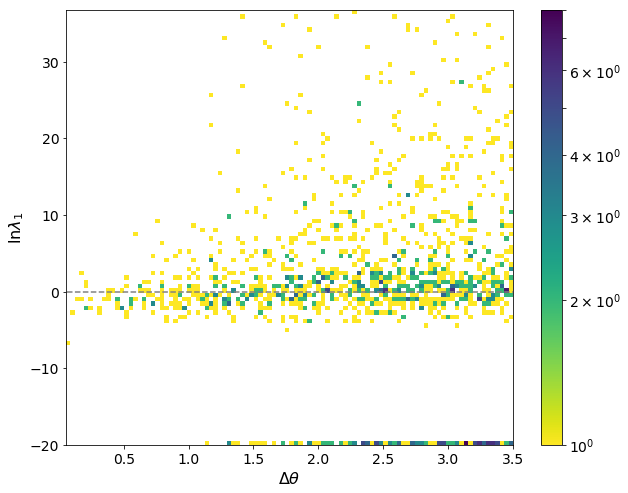

In [180]:
from matplotlib.colors import LogNorm
hist2d(df_result3.SpcAng,df_result3.T1,bins=100,cmap='viridis_r',norm=LogNorm())
colorbar()
xlabel(r"$\Delta \theta$",fontsize=16)
ylabel(r'$\ln \lambda_1$',fontsize=16)
hlines(0,0,3.5,linestyles='--',colors='gray')
savefig("/Users/hugo/AMON/Technical_Notes/IC-HAWC_Analysis/T1vsTheta.pdf")

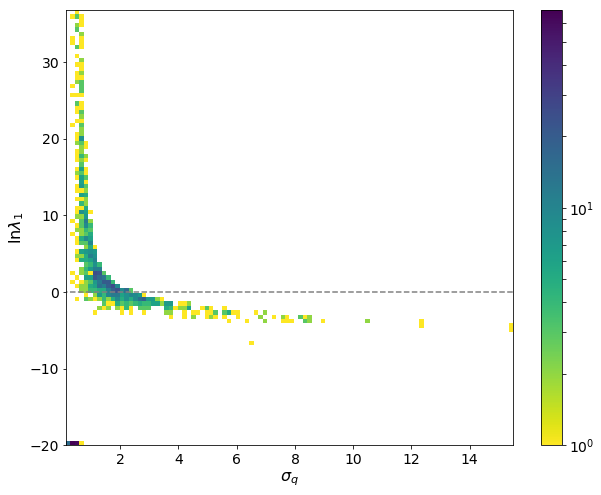

In [181]:
rcParams['figure.figsize'] = (10, 8)
from matplotlib.colors import LogNorm
hist2d(df_result3.Best_pos_err,df_result3.T1,bins=100,cmap='viridis_r',norm=LogNorm())
colorbar()
xlabel(r"$\sigma_q$",fontsize=16)
ylabel(r'$\ln \lambda_1$',fontsize=16)
hlines(0,0,16,linestyles='--',colors='gray')
savefig("/Users/hugo/AMON/Technical_Notes/IC-HAWC_Analysis/T1vssigma.pdf")

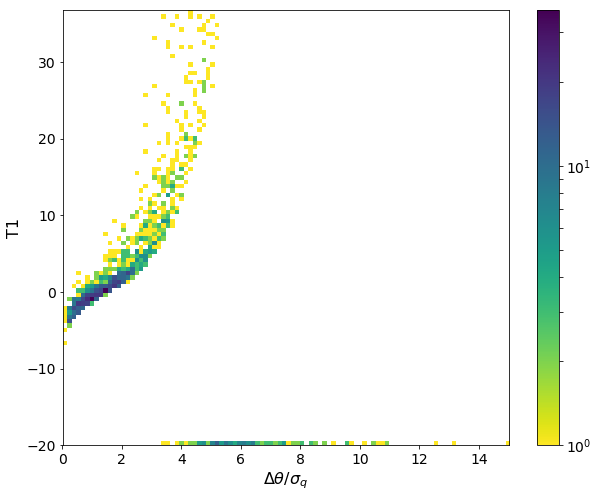

In [182]:
from matplotlib.colors import LogNorm
hist2d(df_result3.SpcAng/df_result3.Best_pos_err,df_result3.T1,bins=100,cmap='viridis_r',norm=LogNorm())
colorbar()
xlabel(r"$\Delta \theta / \sigma_q$",fontsize=16)
ylabel(r'T1',fontsize=16)
savefig("/Users/hugo/AMON/Technical_Notes/IC-HAWC_Analysis/T1vsZ.pdf")

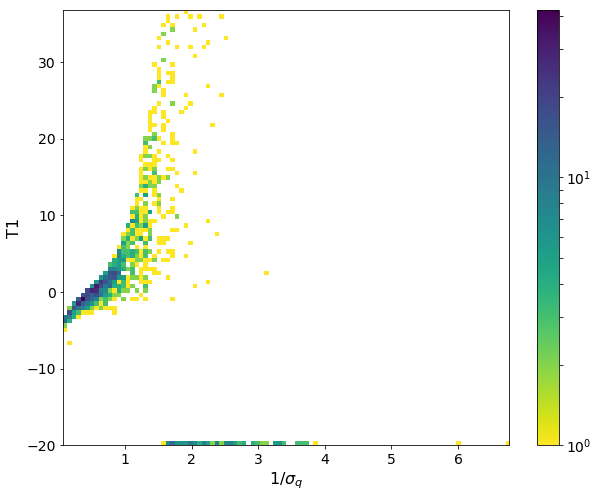

In [183]:
rcParams['figure.figsize'] = (10, 8)
from matplotlib.colors import LogNorm
hist2d(1/df_result3.Best_pos_err,df_result3.T1,bins=100,cmap='viridis_r',norm=LogNorm())
colorbar()
xlabel(r"$1/\sigma_q$",fontsize=16)
ylabel(r'T1',fontsize=16)
#ylim(-1,0)

(0, 0.55)

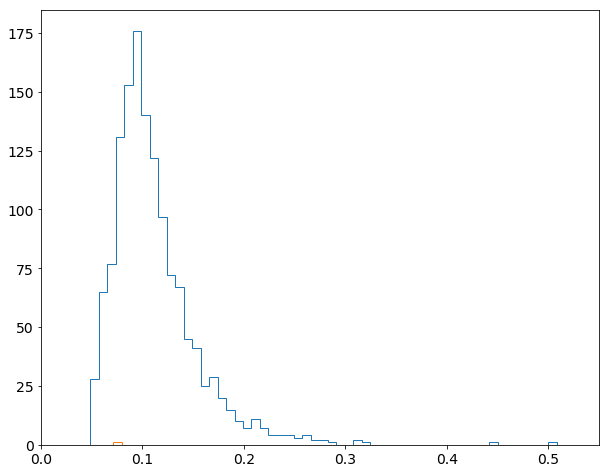

In [218]:
rcParams['figure.figsize'] = (10, 8)
#hist(df_result3.Best_pos_err[df_result3.LLH>-20],bins=50,histtype='step',)
hist(df_result3.Best_pos_err,bins=55,histtype='step')
hist(df_result3.Best_pos_err[df_result3.LLH>48],bins=110,histtype='step')
#hist(df_result3.SigQ,bins=50,histtype='step')
#hist(df_result3.ICDec,bins=50,histtype='step')
xlim(0,0.55)

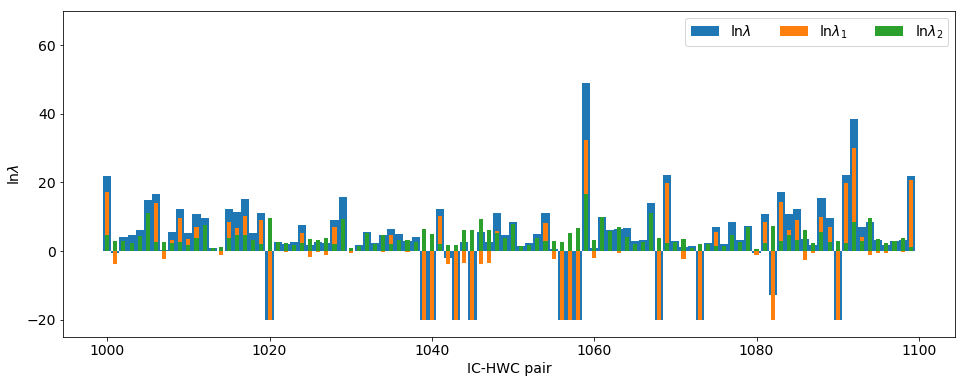

In [185]:
rcParams['figure.figsize']=16,6
x=np.arange(0,len(df_result3))
mini=1000
maxi=1100
bar(x[mini:maxi],df_result3.LLH[mini:maxi],label=r'$\ln \lambda$',width=1)
bar(x[mini:maxi],df_result3.T1[mini:maxi],label=r'$\ln \lambda_1$',width = 0.5)
bar(x[mini:maxi],df_result3.T2[mini:maxi],label=r'$\ln \lambda_2$',width = 0.5)
legend(ncol=3)
xlabel("IC-HWC pair")
ylabel(r"$\ln \lambda$")
ylim(-25,70)
savefig("/Users/hugo/AMON/Technical_Notes/IC-HAWC_Analysis/indllh.pdf")

In [417]:
def smallLikelihood(dst,sigc):
    llh =  - dst**2/(2*sigc)
    return llh

X,Y = meshgrid(df_result3.SpcAng,df_result3.Best_pos_err**2)
Z = smallLikelihood(X,Y).T



In [177]:
max(df_result3.Best_pos_err)

15.477248331498567

In [186]:
Nside = 32
degree = np.pi/180.
sky99 = np.zeros(hp.nside2npix(Nside))
sky95 = np.zeros(hp.nside2npix(Nside))
perc99 = np.percentile(df_result3.LLH,99)
perc95 = np.percentile(df_result3.LLH,95)
for i,r in df_result3.iterrows():
    dec =  r['Best_fit_dec']
    th = 90.-dec
    ra = r['Best_fit_ra']
    j=hp.ang2pix(Nside,th*degree,ra*degree)
    if r['LLH'] > perc99:
        sky99[j] = r["LLH"]
    if r['LLH'] > perc95:
        sky95[j] = r["LLH"]

0.0 180.0 -180.0 180.0
The interval between parallels is 10 deg 0.00'.
The interval between meridians is 10 deg 0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 10 deg 0.00'.
The interval between meridians is 10 deg 0.00'.


48.96561881005988

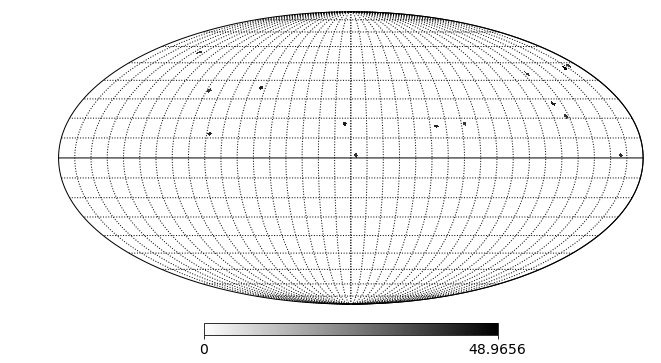

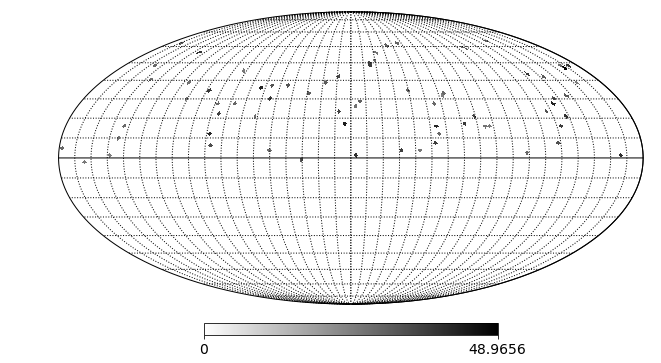

In [187]:
hp.mollview(sky99,rot=180,title='',cmap='gray_r')
hp.graticule(dpar=10)
hp.mollview(sky95,rot=180,title='',cmap='gray_r')
hp.graticule(dpar=10)
np.max(df_result3.LLH)

In [135]:
dfic = pd.read_csv("IC_scrambled/0.csv".format(i))
dfic['ICtime']=pd.to_datetime(dfic['ICtime'])
dfic = dfic.sort_values(by='ICtime')
dfic.head(5)

,ICDec,ICRA,ICsigmaR,ICtime,ICmsec
5147,37.6468,234.510,0.748392,2016-01-01 00:00:40,687458
7014,16.2288,251.664,1.456150,2016-01-01 00:07:29,848553
1218,37.7610,252.420,0.927968,2016-01-01 00:09:24,249790
8163,10.7883,100.428,8.220370,2016-01-01 00:11:59,139309
5878,87.2418,163.700,0.399145,2016-01-01 00:15:36,873420


In [136]:
spca = 3.5
df_result=[]
for i in range(1):
    dfic = pd.read_csv("IC_scrambled/{}.csv".format(i))
    dfic['ICtime']=pd.to_datetime(dfic['ICtime'])
    dfic = dfic.sort_values(by='ICtime')
    df_result.append(spcang_trange_llh(dfic, dfh, spca))
    df_result[i].to_csv("bkg_coinc/IC_HAWC_bkg_{}.csv".format(i),
          index=False,encoding='utf-8')

In [137]:
#1367
len(df_result)
flat = pd.concat(df_result,ignore_index=True)

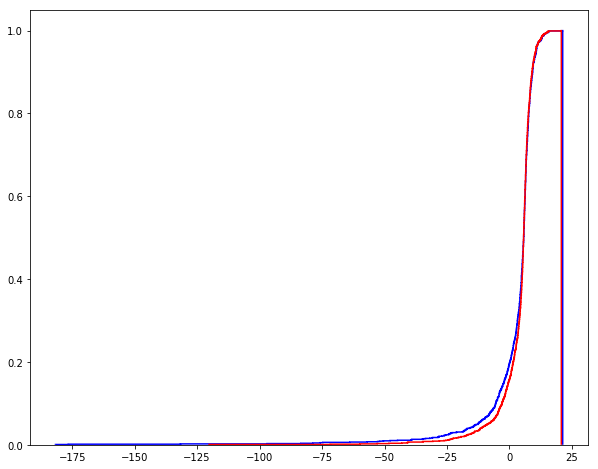

In [138]:
for i in xrange(len(df_result)):
    cllh=plt.hist(df_result[i].LLH1,cumulative=True,normed=1,
         histtype='step',
         color='b',
         lw=1.5,
         bins=2000,
         label='bkg')
    cllh=plt.hist(df_result[i].LLH2,cumulative=True,normed=1,
         histtype='step',
         color='r',
         lw=1.5,
         bins=2000,
         label='bkg')

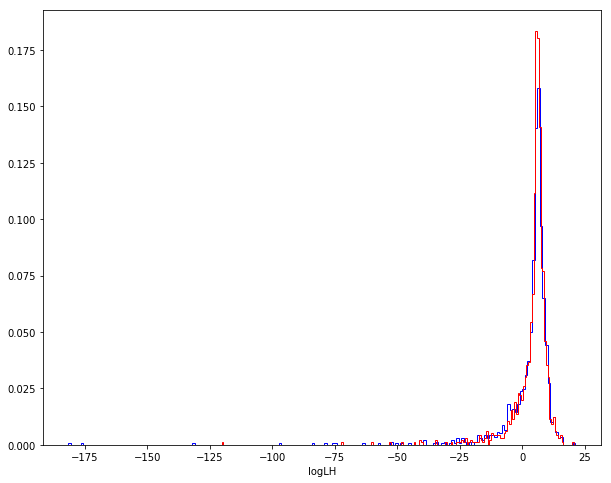

In [139]:
for i in xrange(len(df_result)):
    llh=plt.hist(df_result[i].LLH1,cumulative=False,normed=1,
         histtype='step',
         color='b',
         lw=1.,
         bins=200,
         label='bkg')
    llh=plt.hist(df_result[i].LLH2,cumulative=False,normed=1,
         histtype='step',
         color='r',
         lw=1.,
         bins=200,
         label='bkg')
xlabel("logLH")

(-10, 25)

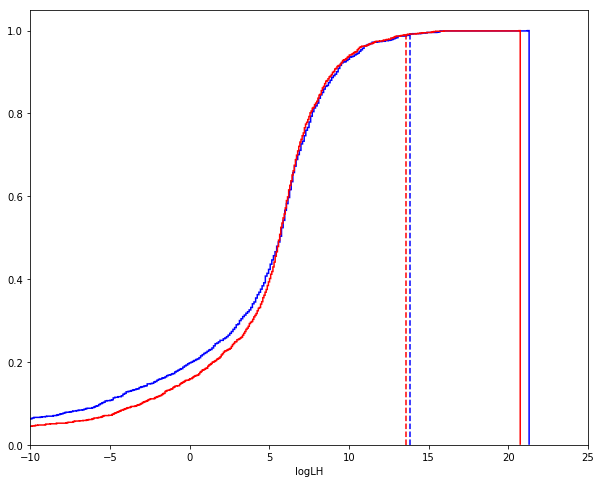

In [141]:
perc1 = np.percentile(flat.LLH1,99)
perc2 = np.percentile(flat.LLH2,99)

cllh=plt.hist(flat.LLH1,cumulative=True,normed=1,
         histtype='step',
         color='b',
         lw=1.5,
         bins=2000,
         label='bkg')
cllh=plt.hist(flat.LLH2,cumulative=True,normed=1,
         histtype='step',
         color='r',
         lw=1.5,
         bins=2000,
         label='bkg')
plt.vlines(perc1,0,0.99,color='blue',linestyles='--')
plt.vlines(perc2,0,0.99,color='red',linestyles='--')
xlabel('logLH')
xlim(-10,25)

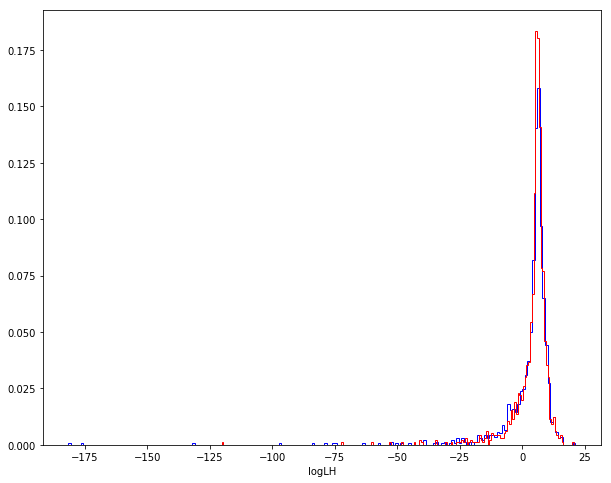

In [145]:
llh=plt.hist(flat.LLH1,cumulative=False,normed=1,
         histtype='step',
         color='b',
         lw=1.,
         bins=200,
         label='bkg')
llh=plt.hist(flat.LLH2,cumulative=False,normed=1,
         histtype='step',
         color='r',
         lw=1.,
         bins=200,
         label='bkg')
xlabel('logLH')


In [19]:
import healpy as hp

In [150]:
Nside = 64
degree = np.pi/180.
sky = np.zeros(hp.nside2npix(Nside))
sky2 = np.zeros(hp.nside2npix(Nside))
perc1 = np.percentile(flat.LLH1,99)
perc2 = np.percentile(flat.LLH2,99)
for i,r in flat.iterrows():
    dec =  r['Best_fit_dec']
    th = 90.-dec
    ra = r['best_fit_ra']
    j=hp.ang2pix(Nside,th*degree,ra*degree)
    if r['LLH1'] > perc1:
        sky[j] = r["LLH1"]
        #print "Time1: ",r['HTime_c']
    if r['LLH1'] > perc2:  
        sky2[j] = r["LLH2"]
        print "Time2: ",r['HTime_c']

Time2:  2016-01-02 14:35:48
Time2:  2016-01-05 04:16:19
Time2:  2016-01-05 04:16:19
Time2:  2016-01-06 09:16:04
Time2:  2016-01-07 00:23:50
Time2:  2016-01-10 21:24:04
Time2:  2016-01-10 23:36:12
Time2:  2016-01-11 23:07:00
Time2:  2016-01-16 10:02:42
Time2:  2016-01-17 10:13:08
Time2:  2016-01-20 12:18:42
Time2:  2016-01-21 06:24:49
Time2:  2016-01-21 22:46:17
Time2:  2016-01-22 15:18:53
Time2:  2016-01-23 13:50:49
Time2:  2016-01-24 16:42:24
Time2:  2016-01-26 00:05:14
Time2:  2016-01-26 15:26:15


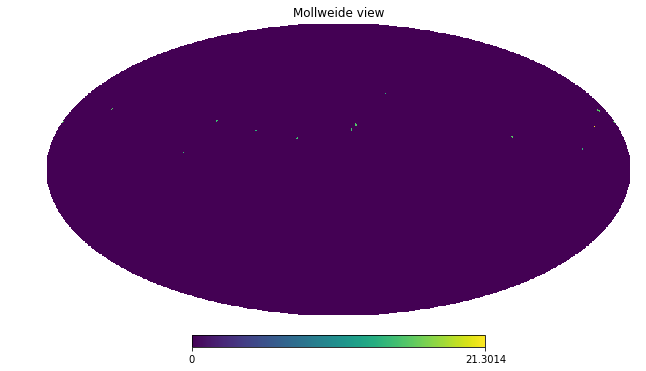

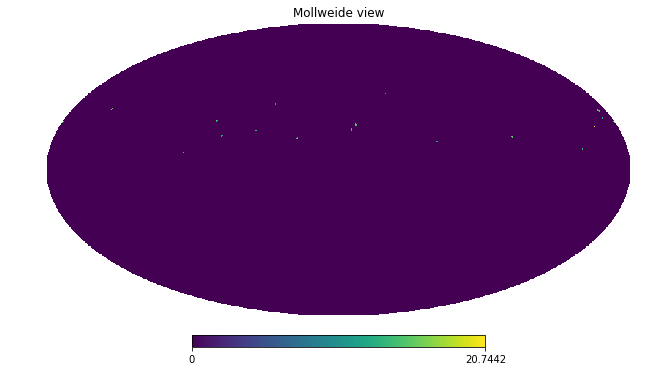

In [147]:
hp.mollview(sky,rot=180,min = 0)
hp.mollview(sky2,rot=180,min = 0)

(array([ 16.,  35.,  34., ...,   0.,   0.,   1.]),
 array([  2.76048605,   2.77841491,   2.79634376, ...,  38.58234092,
         38.60026978,  38.61819863]),
 <a list of 1 Patch objects>)

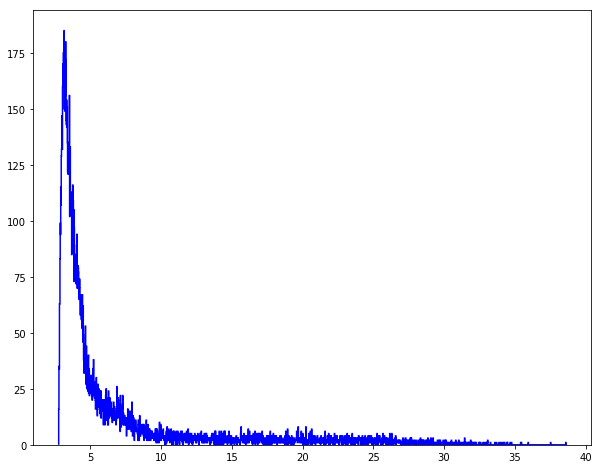

In [45]:
#pvalue = np.log(1-2*scipy.stats.norm.sf(abs(corr_hsig)))
pvalue = corr_hsig
plt.hist(pvalue,
         histtype='step',
         color='b',
         lw=1.5,
         bins=2000,
         label='bkg')

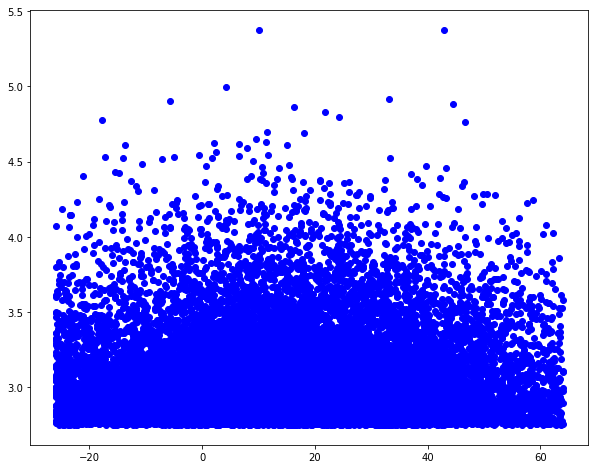

In [52]:
plt.plot(dfh['HDec'],dfh['Hsig'],'o',color='b')

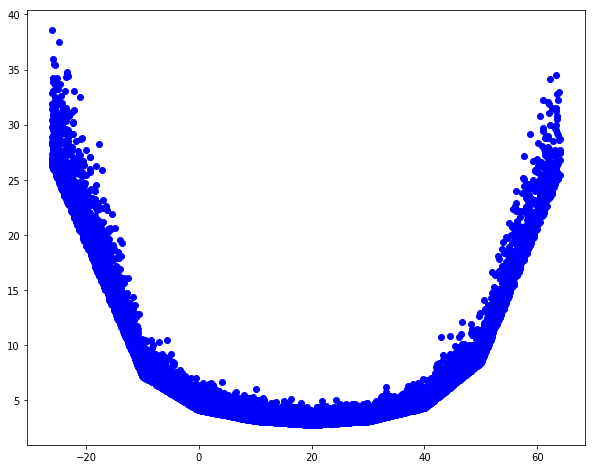

In [53]:
plt.plot(dfh['HDec'],corr_hsig,'o',color='b')

In [49]:
#%%time
#t = 100
#spca = 3.5

#for i in range(100):
#    #df1 = pd.read_csv("/Users/Azadeh/Desktop/Related-AMON/IC-HAWC/files/scrambled/IC-singlet-shuffled_{}.csv".format(i))
#    df1 = pd.read_csv("/Users/Azadeh/Desktop/Related-AMON/IC-HAWC/files/sig_inj/IC_HAWC_sig_inj_{}.csv".format(i))
#    df_result = spcang_time_llh (df1 , df2, t , spca)
#    df_result.to_csv("/Users/Azadeh/Desktop/Related-AMON/IC-HAWC/files/sig_inj_coinc/IC_HAWC_sig_inj_coinc_{}.csv".format(i),
#          index=False,encoding='utf-8')

In [51]:
# OLD FUNCTIONS 2

#def tinterval(t2c,t2d):
#    #standard deviation of a uniform distribution: sigma=sqrt(1/12*(b-a)**2) = 0.288675*t2d -->
#    sigma = 0.288675*t2d*3600.0
#    sigma3 = pd.to_timedelta(3*sigma,unit='s')
#    mint = t2c-sigma3
#    maxt = t2c+sigma3
#    return [mint,maxt]

#def tfunc(t1,t2c,t2d):
#    sigma = 0.288675*t2d*3600.0
#    deltat = (t1-t2c).total_seconds()
#    return np.log(sigma)+abs(deltat)**2/(2*sigma**2)

#def LLH(dec1,ra1,dec2,ra2,sigma1,sigma2,t1,t2c,t2d,sig):
#    if abs(ra1-ra2)>300:
#        if ra1>ra2:
#            ra1=ra1-360
#        else:
#            ra2=ra2-360
#    ra_best = (ra1*sigma2**2+ra2*sigma1**2)/(sigma1**2+sigma2**2)
#    if ra_best < 0 : ra_best_report = ra_best + 360
#    else : ra_best_report = ra_best
#    dec_best = (dec1*sigma2**2+dec2*sigma1**2)/(sigma1**2+sigma2**2)
#    return [dec_best, ra_best_report,
#            ((ra_best-ra1)**2+(dec_best-dec1)**2)/(2*sigma1**2) + 2*np.log(sigma1) + ((ra_best-ra2)**2+(dec_best-dec2)**2)/(2*sigma2**2) + 2*np.log(sigma2) + tfunc(t1,t2c,t2d)-np.log(1-2*scipy.stats.norm.sf(abs(sig)))] 

#def spcang_trange_llh (dfic, dfh, minspc):
#    data_list = []
#    for h in dfh.iterrows():
#        dfw = dfic[(dfic['ICtime']>=tinterval(h[1][4],h[1][6])[0]) & (dfic['ICtime']<=tinterval(h[1][4],h[1][6])[1])]
#        for ic in dfw.iterrows():
#            spc = spcang(h[1][0], ic[1][0], h[1][1], ic[1][1]) 
#            if spc < minspc :
#                llh_list = LLH(ic[1][0],ic[1][1],h[1][0],h[1][1],ic[1][2],h[1][2],ic[1][3],h[1][4],h[1][6],h[1][7])
#                data_list.append((ic[1][0], ic[1][1], ic[1][2], ic[1][3],
#                      h[1][0], h[1][1], h[1][2], h[1][3], h[1][4], h[1][5],h[1][6],h[1][7], spc,
#                                  llh_list[0], llh_list[1], llh_list[2]))
#    result = pd.DataFrame(data_list, columns=['ICDec', 'ICRA' ,'ICsigmaR' ,'ICtime',
#                                              'HDec','HRA','HsigmaR','HTime_i','HTime_c','HTime_f','Hduration','Hsig',
#                                              'SpcAng','Best_fit_dec','best_fit_ra','LLH'])
#    return result

# OLD FUNCTIONS 1

#def deltat (t1,t2):
#    return abs(pd.to_datetime(t1)-pd.to_datetime(t2))

#def spcang_trange_llh (df1, df2, minspc):
#    df1['ICtime']=pd.to_datetime(df1['ICtime'])
#    df1 = df1.sort_values(by='ICtime')
#    data_list = []
#    for i in df1.iterrows():
#        dfw = df2[(pd.to_datetime(df2['HTime_i']) <= pd.to_datetime(i[1][3])) & (pd.to_datetime(df2['HTime_f']) >= pd.to_datetime(i[1][3]))]
#        for j in dfw.iterrows():
#            spc = spcang(i[1][0], j[1][0], i[1][1], j[1][1]) 
#            if spc < minspc :
#                llh_list = LLH(i[1][0],i[1][1],j[1][0],j[1][1],i[1][2],j[1][2],i[1][3],j[1][3],j[1][5],j[1][7])
#                data_list.append((i[1][0], i[1][1], i[1][2], i[1][3], i[1][4],
#                      j[1][0], j[1][1], j[1][2], j[1][3], j[1][4], j[1][5], spc,
#                                  llh_list[0], llh_list[1], llh_list[2]))
#    result = pd.DataFrame(data_list, columns=['ICDec', 'ICRA' ,'ICsigmaR' ,'ICtime','ICmsec',
#                                          'HDec','HRA','HsigmaR','HTime_i','HTime_c','HTime_f','SpcAng',
#                                              'Best_fit_dec','best_fit_ra','LLH'])
#    return result

#def LLH(dec1,ra1,dec2,ra2,sigma1,sigma2):
#    ra_best = (ra1*sigma2**2+ra2*sigma1**2)/(sigma1**2+sigma2**2)
#    dec_best = (dec1*sigma2**2+dec2*sigma1**2)/(sigma1**2+sigma2**2)
#    return [dec_best, ra_best,
#            ((ra_best-ra1)**2+(dec_best-dec1)**2)/sigma1**2 + ((ra_best-ra2)**2+(dec_best-dec2)**2)/sigma2**2]

#def LLH(dec1,ra1,dec2,ra2,sigma1,sigma2):
#    if abs(ra1-ra2)>300:
#        if ra1>ra2:
#            ra1=ra1-360
#        else:
#            ra2=ra2-360
#    ra_best = (ra1*sigma2**2+ra2*sigma1**2)/(sigma1**2+sigma2**2)
#    if ra_best < 0 : ra_best_report = ra_best + 360
#    else : ra_best_report = ra_best
#    dec_best = (dec1*sigma2**2+dec2*sigma1**2)/(sigma1**2+sigma2**2)
#    return [dec_best, ra_best_report,
#            ((ra_best-ra1)**2+(dec_best-dec1)**2)/sigma1**2 + ((ra_best-ra2)**2+(dec_best-dec2)**2)/sigma2**2]

#def spcang_time_llh (df1, df2, tws , minspc):
#    df1['ICtime']=pd.to_datetime(df1['ICtime'])
#    df1 = df1.sort_values(by='ICtime')
#    data_list = []
#    tw = pd.Timedelta(days=0, seconds= tws)
#    for i in df1.iterrows():
#        dfw = df2[abs(pd.to_datetime(df2['HTime']) - pd.to_datetime(i[1][3])) < tw ]
#        for j in dfw.iterrows():
#            spc = spcang(i[1][0], j[1][0], i[1][1], j[1][1]) 
#            if spc < minspc :
#                llh_list = LLH(i[1][0],i[1][1],j[1][0],j[1][1],i[1][2],j[1][2])
#                data_list.append((i[1][0], i[1][1], i[1][2], i[1][3], i[1][4],
#                      j[1][0], j[1][1], j[1][2], j[1][3], j[1][4], spc, deltat(i[1][3],j[1][3]),
#                                  llh_list[0], llh_list[1], llh_list[2]))
#    result = pd.DataFrame(data_list, columns=['ICDec', 'ICRA' ,'ICsigmaR' ,'ICtime','ICmsec',
#                                          'HDec','HRA','HsigmaR','HTime','HMJD','SpcAng','DeltaT',
#                                              'Best_fit_dec','best_fit_ra','LLH'])
#    return result


In [47]:
data = pd.read_csv("IC-singlet-Dec15old-Jan16new-shuffled.csv")
data['ICtime']=pd.to_datetime(data['ICtime'])
data = data.sort_values(by='ICtime')
data.head(4)

,ICDec,ICRA,ICsigmaR,ICtime,ICmsec
7779,71.1671,234.510,1.36859,2016-01-01 00:00:40,687458
5842,56.0493,251.664,1.68801,2016-01-01 00:07:29,848553
5165,82.2661,252.420,3.26689,2016-01-01 00:09:24,249790
7077,84.0186,100.428,1.08596,2016-01-01 00:11:59,139309


In [48]:
from amonpy.dbase.event_to_voevent import event_to_voevent
from amonpy.dbase.db_classes import *
import datetime, dateutil.parser


In [84]:
for d in data.itertuples():
    print str(d['ICtime'])

2016-01-01 00:00:40
2016-01-01 00:07:29
2016-01-01 00:09:24
2016-01-01 00:11:59
2016-01-01 00:15:36
2016-01-01 00:15:54
2016-01-01 00:16:15
2016-01-01 00:24:05
2016-01-01 00:26:27
2016-01-01 00:30:38
2016-01-01 00:43:46
2016-01-01 00:48:46
2016-01-01 00:53:28
2016-01-01 00:55:17
2016-01-01 00:59:41
2016-01-01 01:11:30
2016-01-01 01:20:47
2016-01-01 01:22:26
2016-01-01 01:32:21
2016-01-01 01:33:32
2016-01-01 01:35:20
2016-01-01 01:44:13
2016-01-01 01:49:14
2016-01-01 01:49:22
2016-01-01 01:52:26
2016-01-01 01:58:55
2016-01-01 01:59:11
2016-01-01 02:00:33
2016-01-01 02:11:10
2016-01-01 02:12:07
2016-01-01 02:24:21
2016-01-01 02:27:10
2016-01-01 02:31:20
2016-01-01 02:38:00
2016-01-01 02:42:26
2016-01-01 02:49:49
2016-01-01 02:49:58
2016-01-01 02:50:03
2016-01-01 02:51:56
2016-01-01 02:57:58
2016-01-01 03:05:05
2016-01-01 03:06:15
2016-01-01 03:07:14
2016-01-01 03:15:59
2016-01-01 03:22:59
2016-01-01 03:23:07
2016-01-01 03:26:49
2016-01-01 03:31:46
2016-01-01 03:34:13
2016-01-01 03:37:19


2016-01-04 22:43:44
2016-01-04 22:48:16
2016-01-04 22:48:22
2016-01-04 22:51:14
2016-01-04 23:08:08
2016-01-04 23:11:58
2016-01-04 23:15:01
2016-01-04 23:16:58
2016-01-04 23:25:59
2016-01-04 23:40:56
2016-01-04 23:42:04
2016-01-04 23:42:10
2016-01-04 23:43:12
2016-01-04 23:43:17
2016-01-04 23:53:25
2016-01-04 23:55:45
2016-01-04 23:56:46
2016-01-05 00:19:49
2016-01-05 00:21:32
2016-01-05 00:23:36
2016-01-05 00:24:44
2016-01-05 00:29:26
2016-01-05 00:32:22
2016-01-05 00:34:41
2016-01-05 00:35:08
2016-01-05 00:35:59
2016-01-05 00:37:14
2016-01-05 00:42:24
2016-01-05 00:50:38
2016-01-05 00:52:13
2016-01-05 00:57:25
2016-01-05 00:59:31
2016-01-05 01:01:29
2016-01-05 01:03:12
2016-01-05 01:04:41
2016-01-05 01:06:24
2016-01-05 01:08:20
2016-01-05 01:17:05
2016-01-05 01:31:47
2016-01-05 01:35:07
2016-01-05 01:35:49
2016-01-05 01:39:46
2016-01-05 01:44:50
2016-01-05 01:53:30
2016-01-05 01:54:44
2016-01-05 01:55:01
2016-01-05 01:55:24
2016-01-05 01:56:28
2016-01-05 02:15:38
2016-01-05 02:18:49


2016-01-11 14:19:11
2016-01-11 14:37:27
2016-01-11 14:38:15
2016-01-11 14:38:39
2016-01-11 14:40:37
2016-01-11 14:43:23
2016-01-11 14:44:15
2016-01-11 14:44:18
2016-01-11 14:45:06
2016-01-11 14:48:38
2016-01-11 15:06:30
2016-01-11 15:09:05
2016-01-11 15:09:54
2016-01-11 15:23:25
2016-01-11 15:41:08
2016-01-11 15:41:18
2016-01-11 15:41:50
2016-01-11 15:47:42
2016-01-11 15:50:58
2016-01-11 15:59:59
2016-01-11 16:03:56
2016-01-11 16:07:30
2016-01-11 16:13:23
2016-01-11 16:14:12
2016-01-11 16:27:34
2016-01-11 16:34:43
2016-01-11 16:48:56
2016-01-11 16:50:43
2016-01-11 16:51:33
2016-01-11 17:01:21
2016-01-11 17:02:10
2016-01-11 17:06:57
2016-01-11 17:07:11
2016-01-11 17:11:38
2016-01-11 17:13:59
2016-01-11 17:18:54
2016-01-11 17:19:14
2016-01-11 17:20:10
2016-01-11 17:24:16
2016-01-11 17:30:43
2016-01-11 17:31:03
2016-01-11 17:40:42
2016-01-11 17:51:08
2016-01-11 17:54:19
2016-01-11 18:07:39
2016-01-11 18:09:41
2016-01-11 18:10:00
2016-01-11 18:12:19
2016-01-11 18:23:28
2016-01-11 18:25:35


2016-01-19 11:55:19
2016-01-19 11:56:02
2016-01-19 12:03:41
2016-01-19 12:04:15
2016-01-19 12:09:40
2016-01-19 12:11:34
2016-01-19 12:14:42
2016-01-19 12:21:46
2016-01-19 12:25:35
2016-01-19 12:25:42
2016-01-19 12:33:43
2016-01-19 12:35:32
2016-01-19 12:44:11
2016-01-19 12:49:07
2016-01-19 12:50:12
2016-01-19 12:52:33
2016-01-19 12:53:35
2016-01-19 13:13:53
2016-01-19 13:32:05
2016-01-19 13:40:09
2016-01-19 13:47:21
2016-01-19 13:56:53
2016-01-19 13:59:19
2016-01-19 14:02:03
2016-01-19 14:04:10
2016-01-19 14:05:58
2016-01-19 14:07:06
2016-01-19 14:11:00
2016-01-19 14:12:23
2016-01-19 14:14:51
2016-01-19 14:20:02
2016-01-19 14:33:26
2016-01-19 14:45:23
2016-01-19 14:56:18
2016-01-19 15:09:03
2016-01-19 15:09:11
2016-01-19 15:11:16
2016-01-19 15:14:37
2016-01-19 15:18:02
2016-01-19 15:30:21
2016-01-19 15:30:51
2016-01-19 15:38:58
2016-01-19 15:39:03
2016-01-19 15:39:05
2016-01-19 15:43:12
2016-01-19 15:43:13
2016-01-19 15:47:42
2016-01-19 15:49:31
2016-01-19 15:55:26
2016-01-19 15:56:44


2016-01-27 12:07:58
2016-01-27 12:11:56
2016-01-27 12:17:57
2016-01-27 12:23:38
2016-01-27 12:28:14
2016-01-27 12:28:38
2016-01-27 12:37:37
2016-01-27 12:46:09
2016-01-27 12:53:48
2016-01-27 12:55:20
2016-01-27 12:56:38
2016-01-27 12:57:56
2016-01-27 13:00:08
2016-01-27 13:01:31
2016-01-27 13:06:59
2016-01-27 13:11:30
2016-01-27 13:17:46
2016-01-27 13:24:22
2016-01-27 13:38:45
2016-01-27 13:38:56
2016-01-27 13:59:50
2016-01-27 14:06:34
2016-01-27 14:06:34
2016-01-27 14:09:29
2016-01-27 14:13:36
2016-01-27 14:18:26
2016-01-27 14:24:37
2016-01-27 14:28:25
2016-01-27 14:29:23
2016-01-27 14:32:17
2016-01-27 14:38:58
2016-01-27 14:38:59
2016-01-27 14:44:06
2016-01-27 14:45:56
2016-01-27 14:52:01
2016-01-27 14:53:54
2016-01-27 14:54:43
2016-01-27 14:59:19
2016-01-27 15:03:32
2016-01-27 15:11:26
2016-01-27 15:11:41
2016-01-27 15:12:54
2016-01-27 15:21:49
2016-01-27 15:23:59
2016-01-27 15:37:52
2016-01-27 15:43:34
2016-01-27 15:47:55
2016-01-27 15:56:34
2016-01-27 16:09:48
2016-01-27 16:12:50


In [86]:
i=0
date0 = '2016-01-01'
for d in data.itertuples():
    alert=[Event(0,i,0)]
    parameter = [Parameter("energy",0,i,0)]
    alert[0].type='test'
    alert[0].RA=d[2]
    alert[0].dec=d[1]
    alert[0].sigmaR=d[3]
    alert[0].nevents   =  1
    alert[0].deltaT    =  0.0
    alert[0].false_pos =  0.00
    alert[0].point_RA  =  0.0
    alert[0].point_dec  =  0.0
    alert[0].pvalue    =  0.0
    alert[0].psf_type    =  'fisher'
    alert[0].sigmaT    =  0.0
    alert[0].longitude = 0.0
    alert[0].latitude = -90.
    alert[0].elevation= 2835.
    date = str(d[4])[0:10]+"T"+str(d[4])[11:]
    if str(d[4])[0:10] != date0:
        print i
        date0=str(d[4])[0:10]
    alert[0].datetime = date+"."+str(d[5])
    xml1=event_to_voevent(alert,parameter)
    f = open('../HAWC_pipeline/IC_Test_events/ic_alert_%04d.xml'%(i),'w')
    f.write(xml1)
    f.close()
    i=i+1
#alert[0].forprint()

258
545
830
1084
1361
1605
1890
2177
2430
2697
2968
3249
3497
3760
4031
4298
4595
4847
5086
5327
5622
5911
6173
6434
6703
6984
7241
7519
7784
8024


In [19]:
t=str(data['ICtime'][1])[0:10]+"T"+str(data['ICtime'][1])[11:]
d = dateutil.parser.parse(t)
d.strftime('%m/%d/%Y')

'01/12/2016'

In [146]:
str(data['ICtime'][1])[0:10]

'2016-01-12'

In [93]:
from astropy.time import Time
t=Time(57419.47016,format='mjd')
t.format='isot'
pd.to_datetime(t.value)

Timestamp('2016-02-01 11:17:01.824000')

In [5]:
def extrap1d(interpolator):
    xs = interpolator.x
    ys = interpolator.y

    def pointwise(x):
        if x < xs[0]:
            return ys[0]+(x-xs[0])*(ys[1]-ys[0])/(xs[1]-xs[0])
        elif x > xs[-1]:
            return ys[-1]+(x-xs[-1])*(ys[-1]-ys[-2])/(xs[-1]-xs[-2])
        else:
            return interpolator(x)

    def ufunclike(xs):
        return array(map(pointwise, array(xs)))

    return ufunclike

In [20]:
# declination [deg]
x = [-20, -10, 0, 10, 20, 30, 40, 50, 60] 
# 5 sigma flux [TeV^-1 cm^-2 s^-1]
y = [3.953e-14, 1.491e-14, 8.525e-15, 6.460e-15, 5.724e-15, 6.405e-15, 8.967e-15, 1.737e-14, 4.279e-14] 
func1 = interpolate.interp1d(x,y)
func2 = extrap1d(func1)

In [22]:
flux = func2(dfh['HDec'])
flux20 = 5.724e-15
corr_hsig = dfh['Hsig']*flux/flux20